# Análise de Embeddings dos Hinos da ICM
Este notebook explora técnicas de embeddings para representar os textos dos hinos da coletânea principal da Igreja Cristã Maranata.

O objetivo é aplicar modelos de vetorização, calcular similaridade, realizar agrupamentos e extrair tópicos dos louvores, utilizando métodos como FastText, PCA, t-SNE, UMAP, KMeans, LDA e NMF.

---
**Conteúdo do notebook:**
- Carregamento do modelo FastText e dos dados tratados
- Geração de embeddings com diferentes estratégias de peso
- Cálculo de similaridade entre hinos
- Visualização de matrizes de similaridade
- Redução de dimensionalidade (PCA, t-SNE, UMAP)
- Agrupamento de hinos por KMeans
- Extração de tópicos com LDA e NMF
- Visualização dos agrupamentos e tópicos
- Salvamento dos resultados para uso futuro

Este material é público e pode ser compartilhado para fins de pesquisa, estudo ou divulgação cultural.

# Parte 4 - Embeddings 

---

**A seguir:** Carregamento do modelo FastText pré-treinado para português, utilizado para gerar embeddings das palavras dos hinos.

In [1]:
import fasttext

# Modelo baixado diretamente do site do fasttext
# (https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.bin.gz)
model = fasttext.load_model("..\\assets\\cc.pt.300.bin")

# Outra alternativa
# fasttext.util.download_model('pt', if_exists='ignore')

---

**A seguir:** Carregamento dos dados dos hinos já tokenizados, prontos para análise de embeddings.

In [2]:
import pandas as pd

hinos_analise: pd.DataFrame = pd.read_pickle("..\\assets\\hinos_analise_tokens_ngrams.pkl")

---

**A seguir:** Geração dos embeddings dos hinos utilizando diferentes estratégias de peso: TF-IDF, penalização por comprimento e média uniforme.

In [3]:
import numpy as np
from collections import Counter


def embed_text_weighted(tokens, model, method="tfidf"):
    """Embedding com diferentes estratégias de peso"""
    if not tokens:
        return np.zeros(model.get_dimension())

    vectors = []
    weights = []

    if method == "tfidf":
        # Peso baseado em frequência inversa (palavras raras = mais peso)
        token_counts = Counter(tokens)
        total_docs = len(hinos_analise)  # ou seu corpus total

        for word in tokens:
            vector = model.get_word_vector(word)
            # Simulação simples de TF-IDF
            tf = token_counts[word] / len(tokens)
            idf = np.log(
                total_docs
                / (
                    1
                    + sum(
                        1
                        for doc_tokens in hinos_analise["tokens_no_stops"]
                        if word in doc_tokens
                    )
                )
            )
            weight = tf * idf

            vectors.append(vector)
            weights.append(weight)

    elif method == "uniform":
        # Sua abordagem atual
        vectors = [model.get_word_vector(word) for word in tokens]
        weights = [1.0] * len(vectors)

    elif method == "length_penalty":
        # Penaliza documentos muito longos
        vectors = [model.get_word_vector(word) for word in tokens]
        weights = [1.0 / np.sqrt(len(tokens))] * len(vectors)

    # Média ponderada
    weighted_sum = np.average(vectors, axis=0, weights=weights)
    return weighted_sum


# Teste diferentes abordagens
hinos_analise["word_embedding_tfidf"] = hinos_analise["tokens_no_stops"].apply(
    lambda t: embed_text_weighted(t, model, "tfidf")
)

hinos_analise["word_embedding_length_penalty"] = hinos_analise["tokens_no_stops"].apply(
    lambda t: embed_text_weighted(t, model, "length_penalty")
)

hinos_analise["word_embedding"] = hinos_analise["tokens_no_stops"].apply(
    lambda t: embed_text_weighted(t, model, "uniform")
)
hinos_analise.head()

,nome,texto,texto_limpo,categoria_id,categoria,categoria_abr,tokens,tokens_no_stops,num_tokens,bigrams,trigrams,tokens_str,word_embedding_tfidf,word_embedding_length_penalty,word_embedding
numero,,,,,,,,,,,,,,,
0,AQUILO QUE FUI NÃO SOU MAIS,"AQUILO QUE FUI NÃO SOU MAIS,\nNEM SOU TUDO O Q...","AQUILO QUE FUI NÃO SOU MAIS, NEM SOU TUDO O QU...",1,CLAMOR,CLAMOR,"[aquilo, que, fui, não, sou, mais, nem, sou, t...","[tudo, devo, graça, vê, certo, vou, glória, cr...",124,"[(tudo, devo), (devo, graça), (graça, vê), (vê...","[(tudo, devo, graça), (devo, graça, vê), (graç...",tudo devo graça vê certo vou glória cristo viv...,"[0.008725065032391392, -0.0008341746908318225,...","[0.0005980707660672214, -0.0031036445159568554...","[0.0005980707660672211, -0.0031036445159568554..."
1,O SANGUE DE JESUS TEM PODER,"O SANGUE DE JESUS TEM PODER,\nPODER QUE A MIM ...","O SANGUE DE JESUS TEM PODER, PODER QUE A MIM P...",1,CLAMOR,CLAMOR,"[o, sangue, de, jesus, tem, poder, poder, que,...","[sangue, jesus, pode, valer, comunhão, posso, ...",110,"[(sangue, jesus), (jesus, pode), (pode, valer)...","[(sangue, jesus, pode), (jesus, pode, valer), ...",sangue jesus pode valer comunhão posso sentir ...,"[0.014729981913448603, -0.037387558774790726, ...","[0.019866942830214448, -0.04330812048547984, 0...","[0.019866942830214448, -0.043308120485479856, ..."
2,O SANGUE DE JESUS TEM PODER PARA SALVAR,O SANGUE DE JESUS TEM PODER (2x)\nO SANGUE DE ...,"O SANGUE DE JESUS TEM PODER O SANGUE DE JESUS,...",1,CLAMOR,CLAMOR,"[o, sangue, de, jesus, tem, poder, o, sangue, ...","[sangue, jesus, sangue, jesus, sangue, jesus, ...",50,"[(sangue, jesus), (jesus, sangue), (sangue, je...","[(sangue, jesus, sangue), (jesus, sangue, jesu...",sangue jesus sangue jesus sangue jesus sangue ...,"[0.057089095058556506, -0.02998167634238801, 0...","[0.04426600411534309, -0.04770462671294807, -0...","[0.044266004115343094, -0.04770462671294808, -..."
3,CLAMO A TI,"CLAMO A TI, Ó MEU SENHOR,\nCLAMO A TI, MEU SAL...","CLAMO A TI, Ó MEU SENHOR, CLAMO A TI, MEU SALV...",1,CLAMOR,CLAMOR,"[clamo, a, ti, ó, meu, senhor, clamo, a, ti, m...","[clamo, senhor, clamo, salvador, sangue, vida,...",41,"[(clamo, senhor), (senhor, clamo), (clamo, sal...","[(clamo, senhor, clamo), (senhor, clamo, salva...",clamo senhor clamo salvador sangue vida bendit...,"[-0.01716780801195861, -0.02540245738453506, 0...","[-0.010632061598110285, -0.029406396781696993,...","[-0.010632061598110287, -0.029406396781696993,..."
4,QUANDO TE PROSTRARES,"QUANDO TE PROSTRARES DIANTE DE DEUS,\nLEMBRA Q...","QUANDO TE PROSTRARES DIANTE DE DEUS, LEMBRA QU...",1,CLAMOR,CLAMOR,"[quando, te, prostrares, diante, de, deus, lem...","[prostrares, diante, deus, lembra, jesus, pede...",52,"[(prostrares, diante), (diante, deus), (deus, ...","[(prostrares, diante, deus), (diante, deus, le...",prostrares diante deus lembra jesus pede auxíl...,"[0.011812313638077412, -0.046502881133835154, ...","[0.011535873828941709, -0.04026153570284013, 0...","[0.011535873828941712, -0.04026153570284014, 0..."


---

**A seguir:** Cálculo da similaridade entre hinos usando os embeddings gerados, comparação dos métodos e exibição dos hinos mais semelhantes ao hino de referência.

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

sims_tfidf = cosine_similarity(list(hinos_analise["word_embedding_tfidf"]))
sims_lp = cosine_similarity(list(hinos_analise["word_embedding_length_penalty"]))
sims = cosine_similarity(list(hinos_analise["word_embedding"]))

# hinos mais semelhantes ao hino 443
similarities_tfidf = list(enumerate(sims_tfidf[443]))
similarities_tfidf = sorted(similarities_tfidf, key=lambda x: x[1], reverse=True)

similarities_lp = list(enumerate(sims_lp[443]))
similarities_lp = sorted(similarities_lp, key=lambda x: x[1], reverse=True)

similarities = list(enumerate(sims[443]))
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

print("Mais parecidos com o hino 443: " + hinos_analise["nome"].iloc[443])
print("TF-IDF:")
for idx, score in similarities_tfidf[1:6]:
    print(f"Hino {idx}: {hinos_analise['nome'].iloc[idx]} → similaridade {score:.3f}")

print("Length Penalty:")
for idx, score in similarities_lp[1:6]:
    print(f"Hino {idx}: {hinos_analise['nome'].iloc[idx]} → similaridade {score:.3f}")

print("Uniform:")
for idx, score in similarities[1:6]:
    print(f"Hino {idx}: {hinos_analise['nome'].iloc[idx]} → similaridade {score:.3f}")

Mais parecidos com o hino 443: HÁ UM RIO DE ÁGUAS VIVAS
TF-IDF:
Hino 544: EM BREVE O DIA CHEGARÁ → similaridade 0.781
Hino 59: SE ORARMOS AO SENHOR → similaridade 0.770
Hino 552: PÁTRIA MINHA → similaridade 0.751
Hino 193: AS MUITAS ÁGUAS NÃO PODERIAM APAGAR → similaridade 0.739
Hino 687: QUEM É COMO TU? → similaridade 0.728
Length Penalty:
Hino 230: FONTE DE ÁGUAS VIVAS → similaridade 0.872
Hino 59: SE ORARMOS AO SENHOR → similaridade 0.872
Hino 552: PÁTRIA MINHA → similaridade 0.870
Hino 277: ROCHA ETERNA → similaridade 0.869
Hino 310: MESTRE O MAR SE REVOLTA → similaridade 0.869
Uniform:
Hino 230: FONTE DE ÁGUAS VIVAS → similaridade 0.872
Hino 59: SE ORARMOS AO SENHOR → similaridade 0.872
Hino 552: PÁTRIA MINHA → similaridade 0.870
Hino 277: ROCHA ETERNA → similaridade 0.869
Hino 310: MESTRE O MAR SE REVOLTA → similaridade 0.869


---

**A seguir:** Criação de DataFrames de similaridade para visualização e análise dos resultados dos diferentes métodos de embeddings.

In [5]:
sims_tfidf_df = pd.DataFrame(
    sims_tfidf, index=hinos_analise.index, columns=hinos_analise.index
)
sims_lp_df = pd.DataFrame(
    sims_lp, index=hinos_analise.index, columns=hinos_analise.index
)
sims_df = pd.DataFrame(sims, index=hinos_analise.index, columns=hinos_analise.index)

---

**A seguir:** Visualização das matrizes de similaridade entre hinos utilizando heatmaps para os diferentes métodos de embeddings.

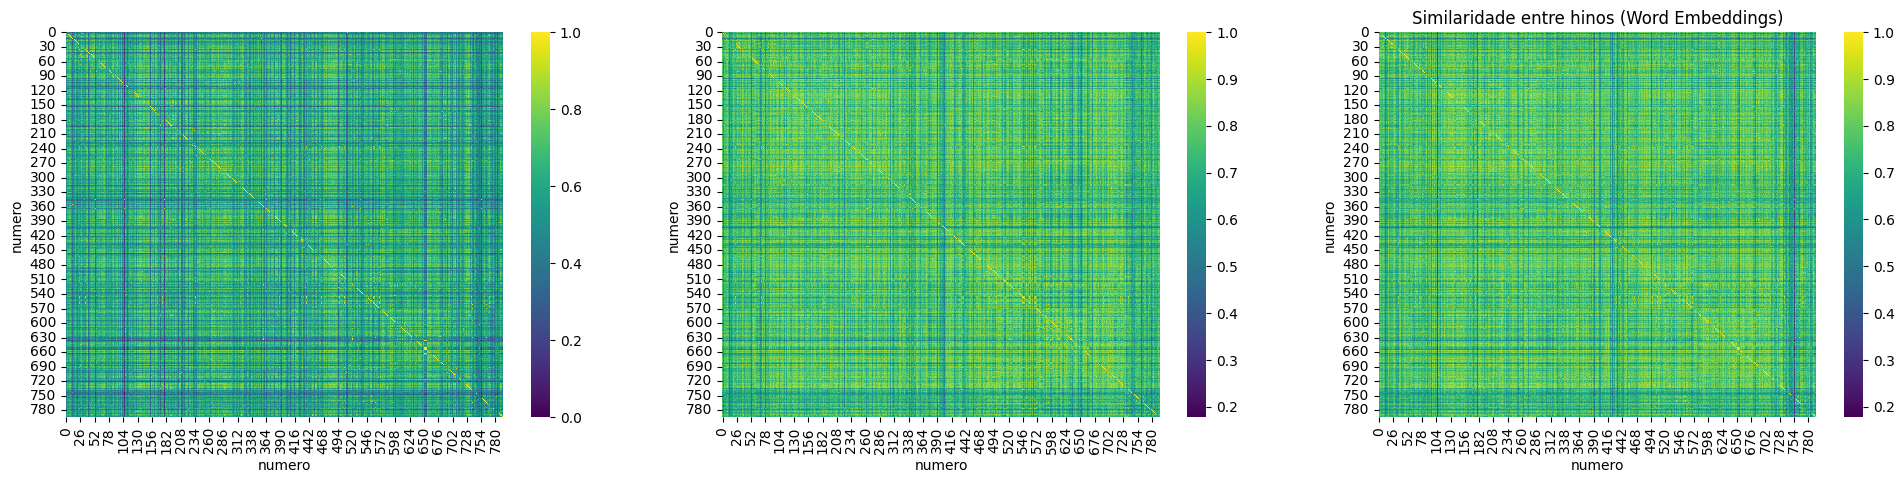

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(24, 5))

sns.heatmap(sims_tfidf_df, cmap="viridis", annot=False, ax=ax[0])
sns.heatmap(sims_lp_df, cmap="viridis", annot=False, ax=ax[1])
sns.heatmap(sims_df, cmap="viridis", annot=False, ax=ax[2])
plt.title("Similaridade entre hinos (Word Embeddings)")
plt.show()

---

**A seguir:** Identificação dos pares de hinos com alta similaridade, destacando possíveis relações temáticas ou estilísticas.

In [7]:
high_similarity_word2vec = sims_tfidf_df[
    (sims_tfidf_df > 0.5) & (sims_tfidf_df < 1.0)
].stack()  # .reset_index()
high_similarity_word2vec = high_similarity_word2vec[
    high_similarity_word2vec.index.get_level_values(0)
    < high_similarity_word2vec.index.get_level_values(1)
]
high_similarity_word2vec.sort_values(ascending=False).head(10)

numero  numero
521     610       0.997771
        632       0.997725
610     632       0.997617
106     179       0.996230
592     630       0.995206
179     755       0.989807
547     569       0.989751
106     755       0.989224
437     547       0.988105
        569       0.988004
dtype: float64

---

**A seguir:** Redução de dimensionalidade dos embeddings dos hinos utilizando PCA, t-SNE e UMAP para visualização e agrupamento.

## Clustering

In [8]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


pca = PCA(n_components=2)
tsne = TSNE(
    n_components=2,  # 2D
    perplexity=30,  # balanceia "quantos vizinhos" considerar (20-50 costuma ser bom)
    # n_iter=1000,  # número de iterações
    random_state=42,
)
umap_model = umap.UMAP(
    n_neighbors=15,  # controla quão “local” é o agrupamento (10–50 bons valores)
    min_dist=0.1,  # densidade dos pontos no espaço 2D (0 = pontos bem juntos, 0.5 = mais espalhados)
    n_components=2,  # queremos 2D para visualização
    random_state=42,
)

X = np.vstack(hinos_analise["word_embedding_tfidf"].values)

X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)
X_umap = umap_model.fit_transform(X)

hinos_analise["word_pca1"] = X_pca[:, 0]
hinos_analise["word_pca2"] = X_pca[:, 1]

hinos_analise["word_tsne1"] = X_tsne[:, 0]
hinos_analise["word_tsne2"] = X_tsne[:, 1]

hinos_analise["word_umap1"] = X_umap[:, 0]
hinos_analise["word_umap2"] = X_umap[:, 1]

c:\ProgramData\anaconda3\envs\jupyters\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


---

**A seguir:** Visualização dos agrupamentos dos hinos por embeddings reduzidos, utilizando scatterplots para PCA, t-SNE e UMAP.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10732\3998726163.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10732\3998726163.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10732\3998726163.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend(bbox_to_anchor=(1.05, 1), loc="upper left")


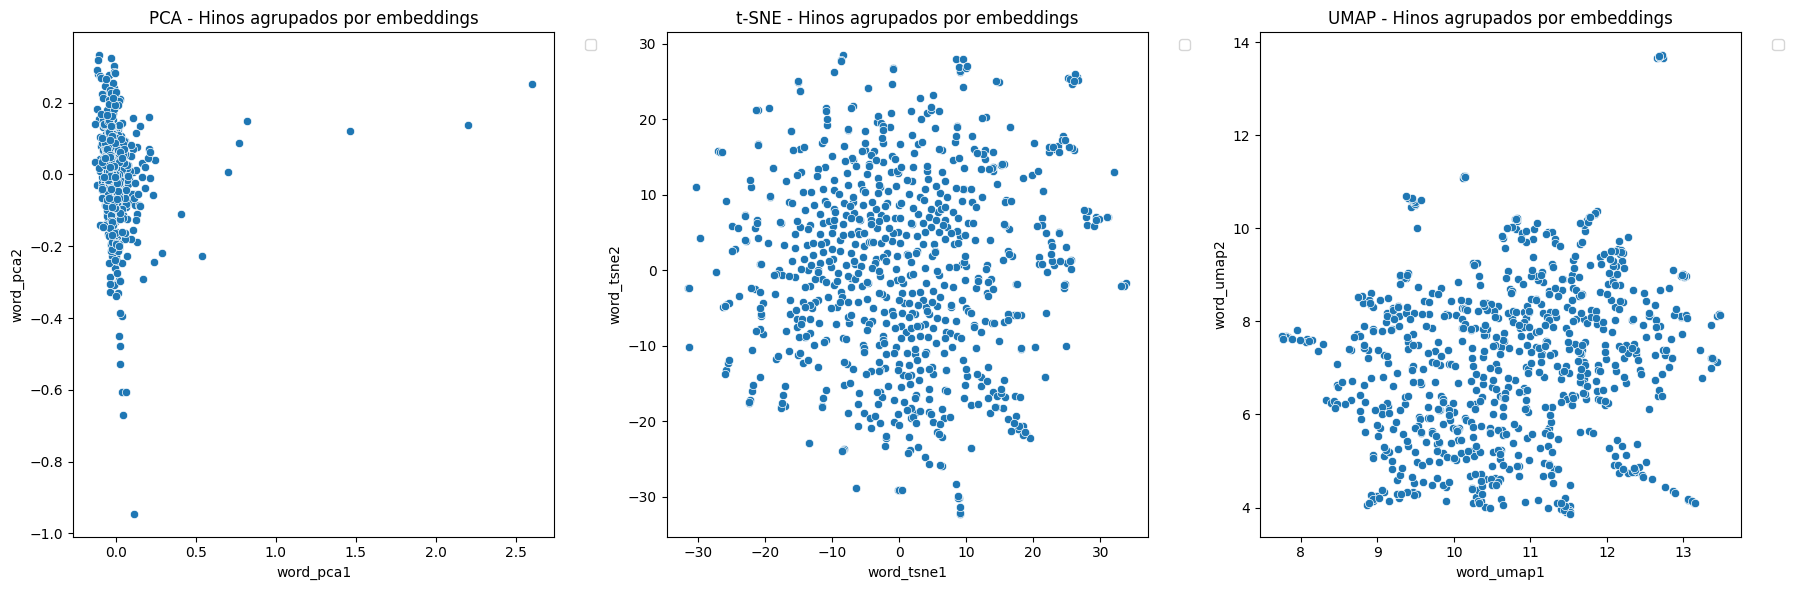

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar figura com 3 subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot PCA
sns.scatterplot(
    data=hinos_analise,
    x="word_pca1",
    y="word_pca2",
    ax=axes[0],
)
axes[0].set_title("PCA - Hinos agrupados por embeddings")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot t-SNE
sns.scatterplot(
    data=hinos_analise,
    x="word_tsne1",
    y="word_tsne2",
    ax=axes[1],
)
axes[1].set_title("t-SNE - Hinos agrupados por embeddings")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot UMAP
sns.scatterplot(
    data=hinos_analise,
    x="word_umap1",
    y="word_umap2",
    ax=axes[2],
)
axes[2].set_title("UMAP - Hinos agrupados por embeddings")
axes[2].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

---

**A seguir:** Análise de agrupamento dos hinos utilizando KMeans, avaliação do número ideal de clusters com o coeficiente de Silhouette.

k = 2, silhouette = 0.3972
k = 3, silhouette = 0.3590
k = 4, silhouette = 0.3833
k = 5, silhouette = 0.3641
k = 6, silhouette = 0.3489
k = 7, silhouette = 0.3393
k = 8, silhouette = 0.3297
k = 9, silhouette = 0.3453
k = 10, silhouette = 0.3629
k = 11, silhouette = 0.3296


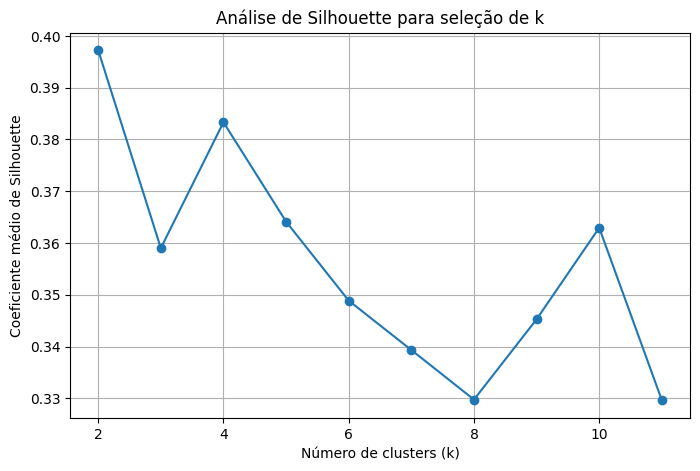

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

range_n_clusters = range(2, 12)
silhouette_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap)
    score = silhouette_score(X_umap, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, silhouette = {score:.4f}")

# Visualiza o resultado
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker="o")
plt.title("Análise de Silhouette para seleção de k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coeficiente médio de Silhouette")
plt.grid(True)
plt.show()

---

**A seguir:** Visualização dos coeficientes de Silhouette para diferentes valores de k, auxiliando na escolha do número de clusters ideal.

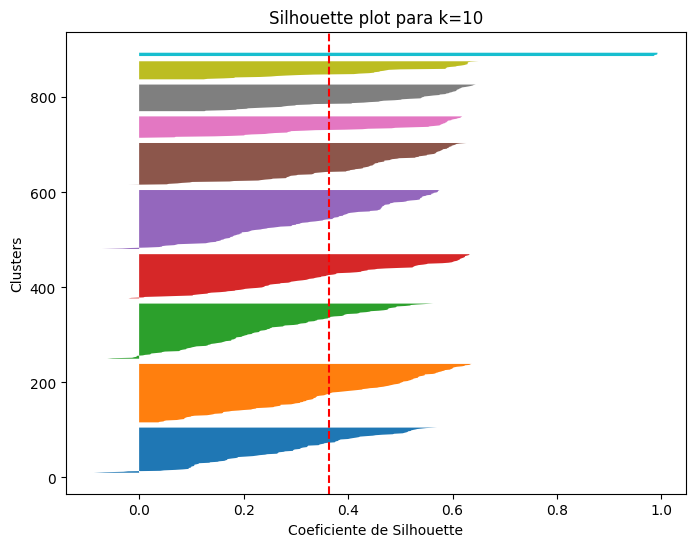

In [11]:
from sklearn.metrics import silhouette_samples
import numpy as np

k = 10  # exemplo, número escolhido
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_umap)

silhouette_vals = silhouette_samples(X_umap, labels)
y_lower = 10

plt.figure(figsize=(8, 6))
for i in range(k):
    ith_vals = silhouette_vals[labels == i]
    ith_vals.sort()
    size_cluster_i = ith_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals)
    y_lower = y_upper + 10

plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
plt.title(f"Silhouette plot para k={k}")
plt.xlabel("Coeficiente de Silhouette")
plt.ylabel("Clusters")
plt.show()

---

**A seguir:** Visualização dos coeficientes de Silhouette por cluster, detalhando a qualidade dos agrupamentos formados.

In [12]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
hinos_analise["word_cluster"] = kmeans.fit_predict(X_umap)

---

**A seguir:** Atribuição dos clusters aos hinos e visualização dos agrupamentos por embeddings reduzidos.

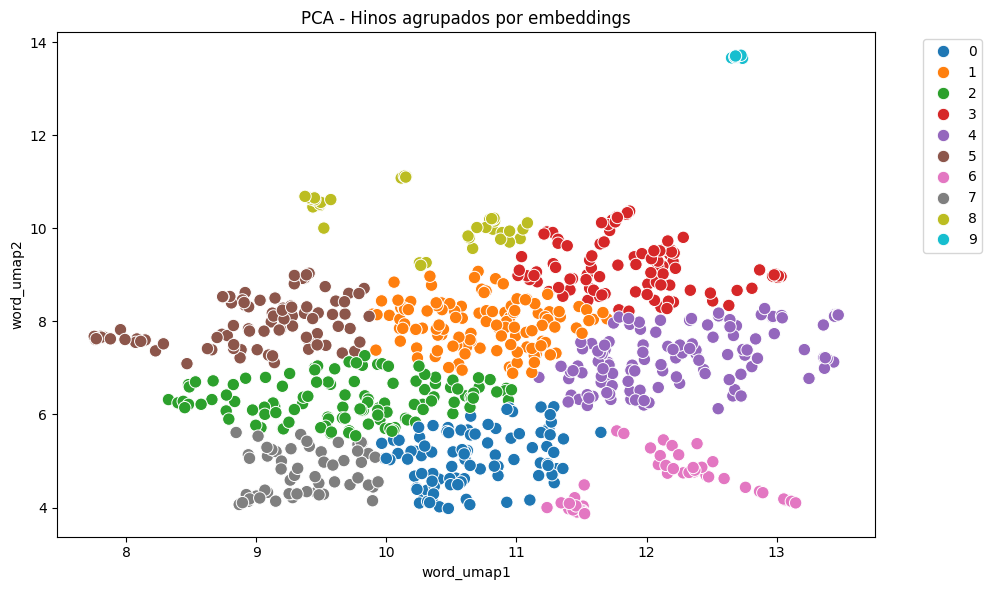

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar figura com 3 subplots lado a lado
plt.figure(figsize=(10, 6))

# Plot PCA
sns.scatterplot(
    data=hinos_analise,
    x="word_umap1",
    y="word_umap2",
    hue="word_cluster",
    palette="tab10",
    s=80,
)
plt.title("PCA - Hinos agrupados por embeddings")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

---

**A seguir:** Análise dos termos mais frequentes em cada cluster e visualização da distribuição dos hinos por cluster.

In [20]:
from collections import Counter

for c in sorted(hinos_analise["word_cluster"].unique()):
    cluster_tokens = hinos_analise.loc[
        hinos_analise["word_cluster"] == c, "tokens_no_stops"
    ].sum()
    top_terms = Counter(cluster_tokens).most_common(10)
    print(f"\nCluster {c}:")
    print([t for t, _ in top_terms])
    print(hinos_analise.loc[hinos_analise["word_cluster"] == c, "nome"][:3])


Cluster 0:
['senhor', 'deus', 'jesus', 'tudo', 'amor', 'vai', 'cristo', 'coração', 'vida', 'hoje']
numero
4     QUANDO TE PROSTRARES
6       JESUS, Ó MEU JESUS
9    SENHOR, ME CHEGO A TI
Name: nome, dtype: object

Cluster 1:
['jesus', 'senhor', 'sangue', 'amor', 'deus', 'glória', 'vida', 'cristo', 'paz', 'graça']
numero
1                O SANGUE DE JESUS TEM PODER
2    O SANGUE DE JESUS TEM PODER PARA SALVAR
3                                 CLAMO A TI
Name: nome, dtype: object

Cluster 2:
['jesus', 'senhor', 'céu', 'dia', 'amor', 'voz', 'vem', 'deus', 'luz', 'cristo']
numero
16              SE ANDARMOS NA LUZ
18    PROSTRADO ESTOU DIANTE DE TI
23    SENHOR, OUVE A MINHA  ORAÇÃO
Name: nome, dtype: object

Cluster 3:
['deus', 'senhor', 'santo', 'jesus', 'glória', 'nome', 'amor', 'cristo', 'louvor', 'terra']
numero
56                           VITÓRIA SOBRE VITÓRIA
73                             DEUS ESTÁ NO TEMPLO
79    DEUS ESTÁ PRESENTE ENTRE  PECADORES COMO NÓS
Name: nome, dtype: ob

In [21]:
print(hinos_analise["word_cluster"].value_counts().sort_index())

word_cluster
0     96
1    124
2    117
3     94
4    125
5     89
6     46
7     57
8     39
9      8
Name: count, dtype: int64


---

**A seguir:** Extração de tópicos dos hinos utilizando LDA e NMF, atribuição dos tópicos aos hinos e visualização da distribuição dos tópicos.

## Tópicos

---

**A seguir:** Visualização dos agrupamentos dos hinos por tópicos, utilizando scatterplots para PCA, t-SNE e UMAP.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

n_topics = n_clusters

# Criar TF-IDF apenas para análise de tópicos
vectorizer = TfidfVectorizer(
    max_features=500,
    stop_words=None,  # você já removeu as stopwords
    ngram_range=(1, 3),  # uni, bi e trigramas
    min_df=2,  # palavra deve aparecer em pelo menos 2 documentos
)

# Usar texto já limpo (sem stopwords)
texts_for_topics = [" ".join(tokens) for tokens in hinos_analise["tokens_no_stops"]]
X_tfidf = vectorizer.fit_transform(texts_for_topics)

# Agora podemos usar LDA e NMF
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
lda_topics = lda.fit_transform(X_tfidf)

# NMF também funciona com TF-IDF
nmf = NMF(n_components=n_topics, random_state=42, max_iter=100)
nmf_topics = nmf.fit_transform(X_tfidf)


def display_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTópico {idx+1}:")
        top_words = [feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]
        print(f"Palavras-chave: {' | '.join(top_words)}")


feature_names = vectorizer.get_feature_names_out()

print("=== LDA (Latent Dirichlet Allocation) ===")
display_topics(lda, feature_names)

print("\n=== NMF (Non-negative Matrix Factorization) ===")
display_topics(nmf, feature_names)

# Atribuir tópicos aos hinos
hinos_analise["LDA_topic"] = lda_topics.argmax(axis=1)
hinos_analise["NMF_topic"] = nmf_topics.argmax(axis=1)

=== LDA (Latent Dirichlet Allocation) ===

Tópico 1:
Palavras-chave: senhor | deus | cada | terra | senhor deus | louvai | amor | louvarei | sempre | nome

Tópico 2:
Palavras-chave: alma | precioso | noite | entrego | fica | sinto | altar | senhor | satisfaz | nunca

Tópico 3:
Palavras-chave: varões | deus | céu terra | virá | glória | vem jesus | mar | proverá | deus proverá | manda

Tópico 4:
Palavras-chave: glória | glória glória | vem | glória glória glória | espírito | amado | deus | servas | jerusalém | rio

Tópico 5:
Palavras-chave: adoração | rosto | louvando | lindo | santos | lindo céu | obra | senhor | olhai | misericórdia

Tópico 6:
Palavras-chave: senhor | quero | aleluia | jesus | sangue | presença | fé | amor | deus | somente

Tópico 7:
Palavras-chave: santo santo | santo | santo santo santo | renova | melhor | vez | volta | lugar | temporal | firme

Tópico 8:
Palavras-chave: jesus | amor | deus | cristo | vida | senhor | cruz | paz | glória | rei

Tópico 9:
Palavras-cha

In [23]:
print(f"\nDistribuição LDA:")
print(hinos_analise["LDA_topic"].value_counts().sort_index())

print(f"\nDistribuição NMF:")
print(hinos_analise["NMF_topic"].value_counts().sort_index())


Distribuição LDA:
LDA_topic
0     99
1     31
2     19
3     24
4      4
5    144
6      9
7    427
8      5
9     33
Name: count, dtype: int64

Distribuição NMF:
NMF_topic
0    148
1    115
2     81
3    137
4     53
5     56
6     30
7     73
8     38
9     64
Name: count, dtype: int64


---

**A seguir:** Visualização da distribuição dos tópicos atribuídos aos hinos por LDA e NMF.

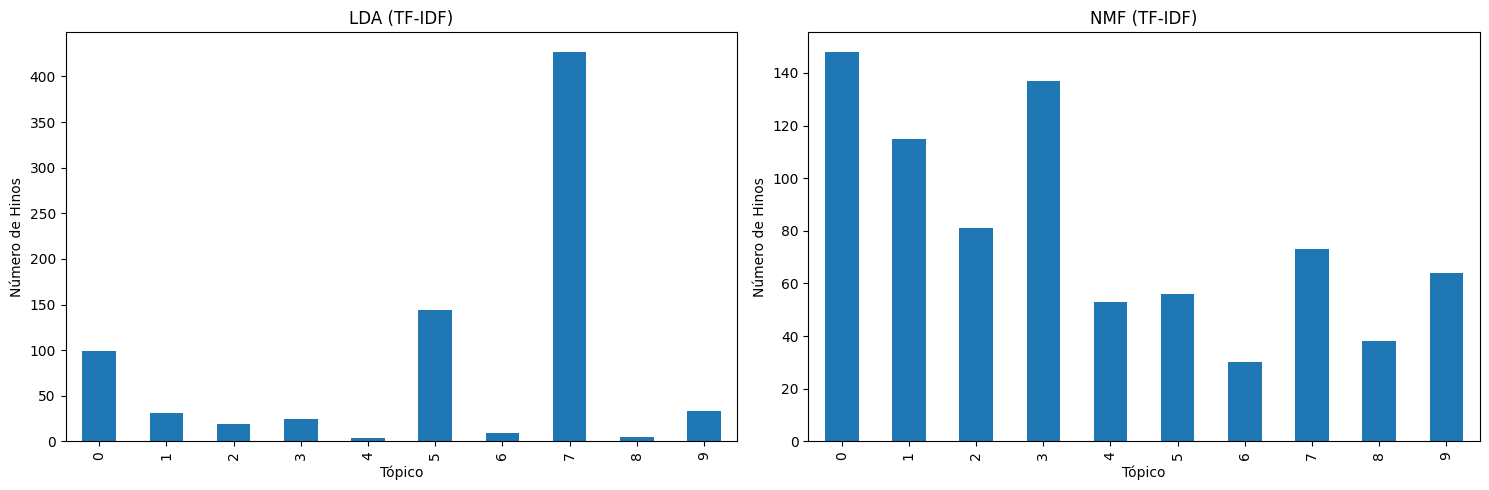

In [16]:
# Visualizar a distribuição de tópicos
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# LDA
hinos_analise["LDA_topic"].value_counts().sort_index().plot(
    kind="bar", ax=axes[0], title="LDA (TF-IDF)"
)
axes[0].set_xlabel("Tópico")
axes[0].set_ylabel("Número de Hinos")

# NMF
hinos_analise["NMF_topic"].value_counts().sort_index().plot(
    kind="bar", ax=axes[1], title="NMF (TF-IDF)"
)
axes[1].set_xlabel("Tópico")
axes[1].set_ylabel("Número de Hinos")

plt.tight_layout()
plt.show()

---

**A seguir:** Visualização dos agrupamentos dos hinos por tópicos em diferentes projeções (PCA, t-SNE, UMAP).

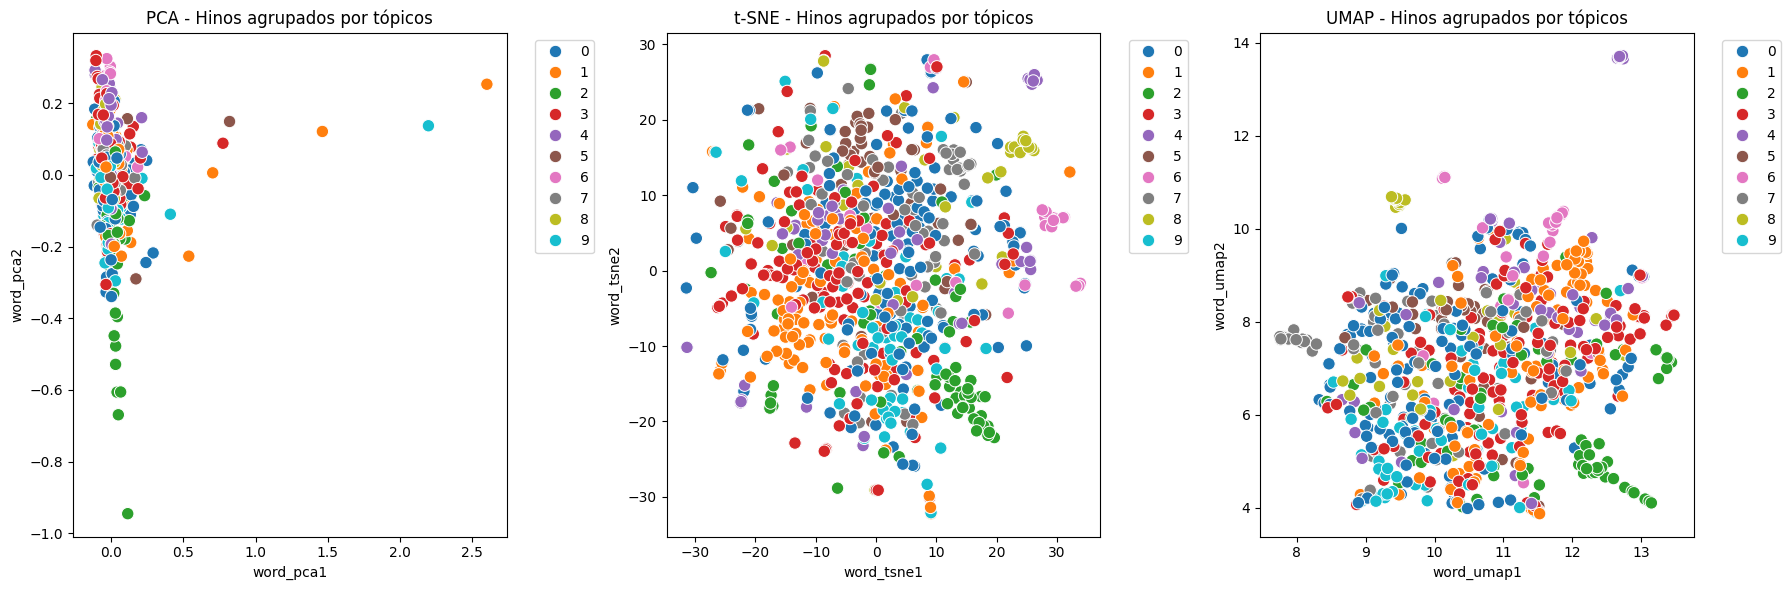

In [17]:
# Criar figura com 3 subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot PCA
sns.scatterplot(
    data=hinos_analise,
    x="word_pca1",
    y="word_pca2",
    hue="NMF_topic",
    palette="tab10",
    s=80,
    ax=axes[0],
)
axes[0].set_title("PCA - Hinos agrupados por tópicos")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot t-SNE
sns.scatterplot(
    data=hinos_analise,
    x="word_tsne1",
    y="word_tsne2",
    hue="NMF_topic",
    palette="tab10",
    s=80,
    ax=axes[1],
)
axes[1].set_title("t-SNE - Hinos agrupados por tópicos")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot UMAP
sns.scatterplot(
    data=hinos_analise,
    x="word_umap1",
    y="word_umap2",
    hue="NMF_topic",
    palette="tab10",
    s=80,
    ax=axes[2],
)
axes[2].set_title("UMAP - Hinos agrupados por tópicos")
axes[2].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

---

**A seguir:** Salvamento dos resultados e informações enriquecidas dos hinos para uso em análises futuras.

## Salvamento de informações novas

---

**Fim do notebook:** Finalização do processamento, com os dados prontos para exportação e uso em outras análises ou aplicações.

In [18]:
hinos_analise[
    [
        "nome",
        "texto_limpo",
        "categoria_id",
        "categoria_abr",
        "tokens_no_stops",
        "word_embedding_tfidf",
        "word_tsne1",
        "word_tsne2",
        "word_umap1",
        "word_umap2",
        "word_cluster",
        "NMF_topic",
    ]
].to_pickle("..\\assets\\hinos_analise_word_embeddings.pkl")

In [19]:
sims_tfidf_df.to_pickle("..\\assets\\similarity_matrix_word_embeddings_tfidf.pkl")